In [1]:
import pandas as pd
from utils.data_loader import DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from utils.kmeans import ClusterEvaluator
import matplotlib.pyplot as plt
import numpy as np

# Explotary Data Analysis (EDA)

In [2]:
dataset = ['scrapper/debat_tv_one.csv',
        'scrapper/Ijasah_ditunjukan.csv',
        'scrapper/komentar_pihak_yang_dituduh.csv',
        'scrapper/komentar_tokoh_politik.csv',
        'scrapper/teman_kuliah.csv'
        ]

loader = DataLoader(dataset)

for df in loader.load_data():
    print(df.info())
    print('\n')
    print('='*50)
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18638 entries, 0 to 18637
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   author        18638 non-null  object
 1   text          18638 non-null  object
 2   published_at  18638 non-null  object
 3   like_count    18638 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 582.6+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44359 entries, 0 to 44358
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   author        44359 non-null  object
 1   text          44359 non-null  object
 2   published_at  44359 non-null  object
 3   like_count    44359 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.4+ MB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------       

The visualization indicates that many users commented multiple times, as evidenced by the number of unique author values being significantly lower than the number of unique text entries across all datasets. The nearly equal count of unique published_at and text values suggests that comments were posted at different times, reflecting organic user engagement rather than automated or mass-posted activity. In contrast, the like_count column shows very few unique values, implying that most comments received similar numbers of likes or were not liked at all. Overall, this suggests that while user participation in commenting was active and sustained over time, interaction through likes was relatively low, pointing to a more expressive than reactive user behavior.

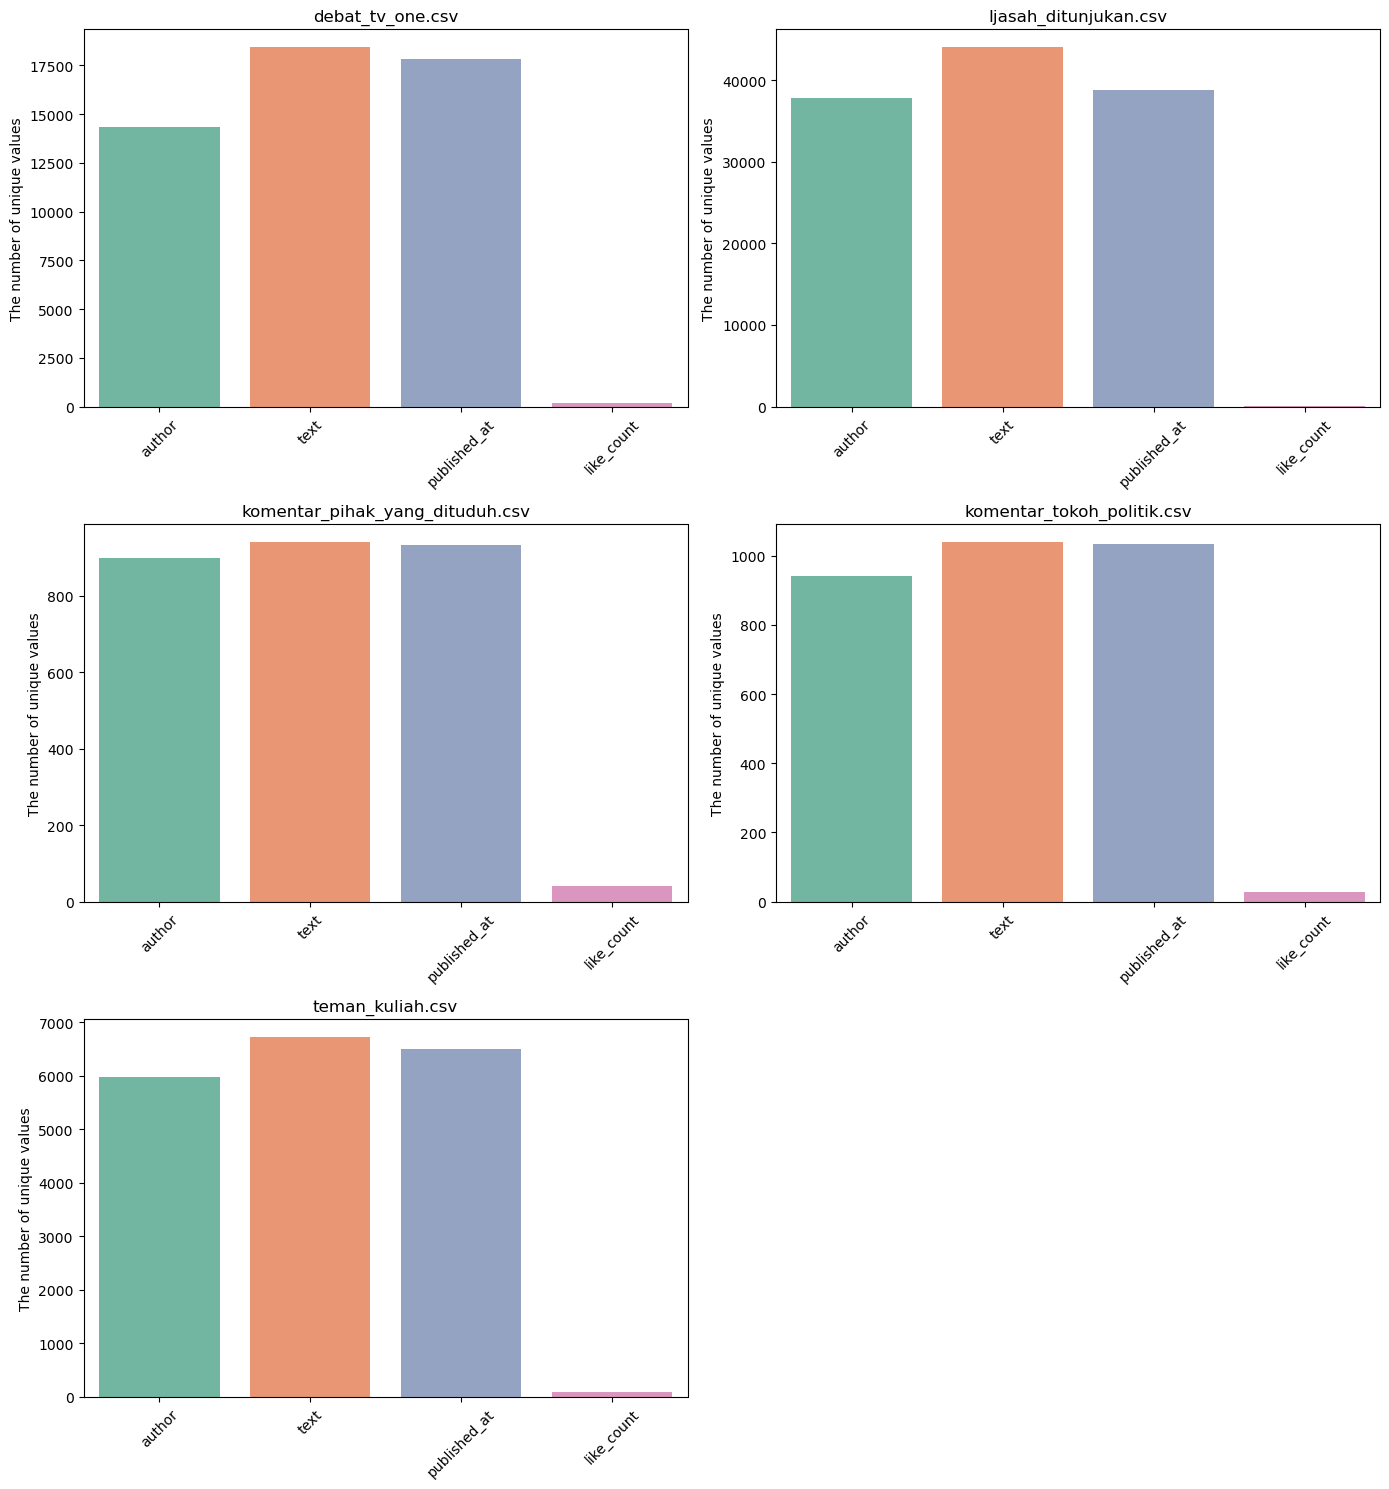

In [3]:
loader.check_unique_values()

The time series plots show a clear pattern of high initial comment volume followed by a rapid decline over subsequent days across all datasets. This suggests that public engagement was strongly event-driven, with most users reacting intensely on or shortly after the news or incident occurred. For instance, files like debat_tv_one.csv and ijasah_ditunjukan.csv show a sharp spike in comments on the first day, reaching thousands of responses, then dropping significantly in the following days. This temporal concentration implies that attention and conversation peaked immediately and quickly faded, likely reflecting how news cycles or trending topics dominate public discourse briefly before being replaced by other issues. The decay is steep and consistent across datasets, reinforcing the idea that online commentary in these contexts is short-lived, highly reactive, and time-sensitive.

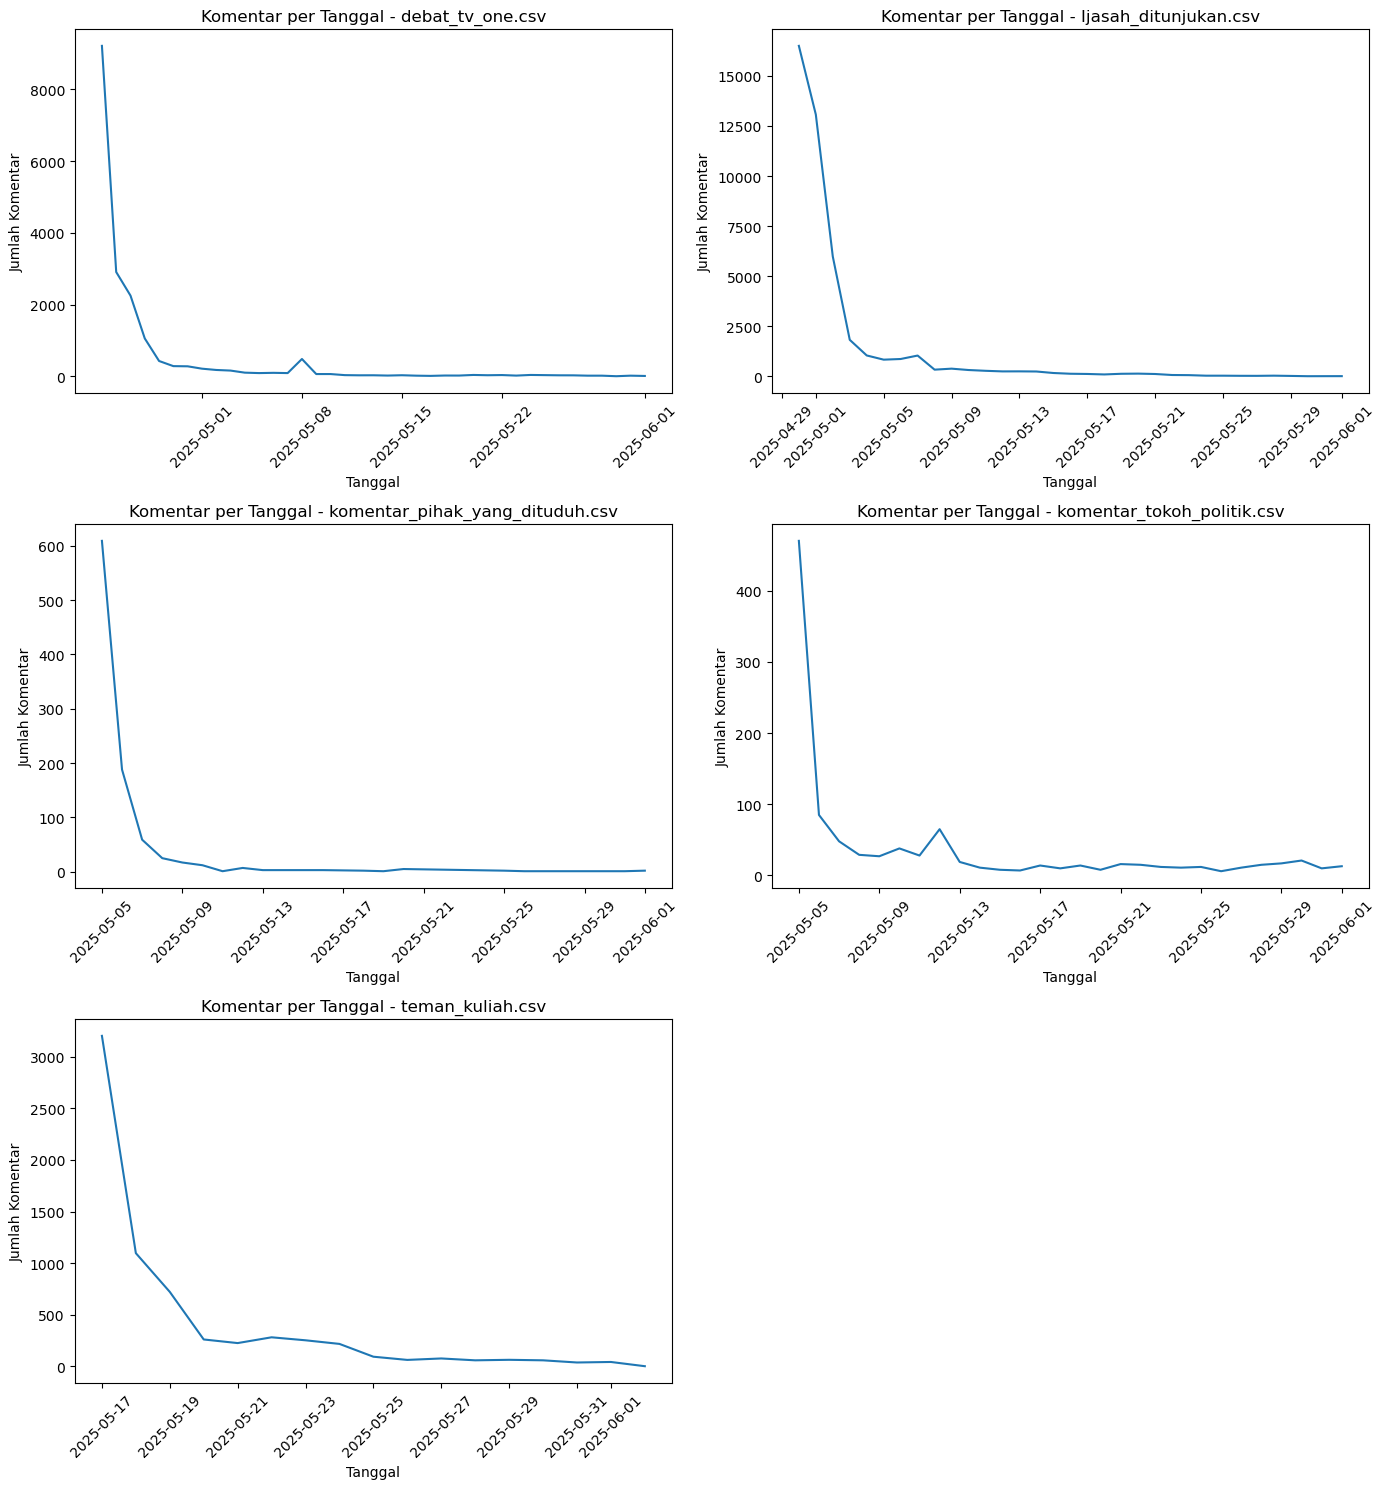

In [4]:
loader.plot_comment_times()

In [5]:
# TODO: Provide analysis of the data per hour
# TODO: Provide analysis of User

In [6]:
df_komentar = {
    path.split('/')[-1].replace('.csv', ''): loader.data_preprocessor(path, text_col='text')
    for path in dataset
}

df_all = pd.concat(df_komentar.values(), ignore_index=True)

In [7]:
train_df, val_df, test_df = loader.data_splitter(df_all, text_col='text', test_size=0.1, val_size=0.2)

Train set: 50217 rows
Validation set: 14348 rows
Test set: 7174 rows


In [8]:
vectorizer = TfidfVectorizer()
train = vectorizer.fit_transform(train_df['text'].tolist())
val = vectorizer.transform(val_df['text'].tolist())
test = vectorizer.transform(test_df['text'].tolist())

# KMeans Clustering

In [9]:
training_playground = {
    'Train': train,
    'Validation': val,
    'Test': test
}

cluster_range = range(2, 100, 5)
results = {}

for name, data in training_playground.items():
    evaluator = ClusterEvaluator(data, cluster_range)
    silhouettes = []
    inertias = []
    for result in evaluator.evaluate_kmeans():
        silhouettes.append(result['silhouette_score'])
        inertias.append(result['inertia'])
    results[name] = {
        'silhouette': silhouettes,
        'inertia': inertias
    }

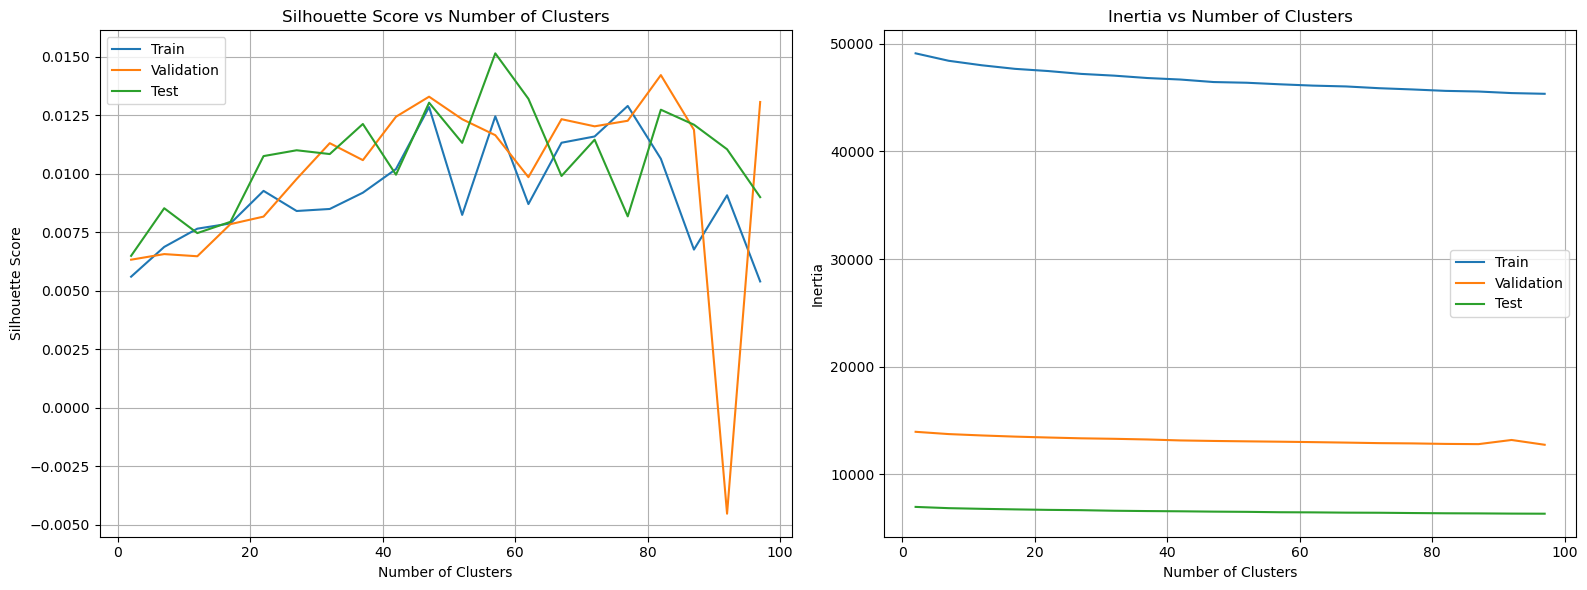

In [12]:
cluster_list = list(cluster_range)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
for name in results:
    axs[0].plot(cluster_list, results[name]['silhouette'], label=name)
axs[0].set_title('Silhouette Score vs Number of Clusters')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')
axs[0].grid(True)
axs[0].legend()
for name in results:
    axs[1].plot(cluster_list, results[name]['inertia'], label=name)
axs[1].set_title('Inertia vs Number of Clusters')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Inertia')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()


Based on the clustering evaluation results, the optimal number of clusters appears to be in the range of 50 to 60, where the silhouette scores peak consistently across train, validation, and test sets, indicating strong and well-separated clusters. Although inertia continues to decrease with more clusters, it does not show a clear elbow point, making it less reliable for determining the best k. In contrast, the silhouette score highlights a performance drop beyond 65 clusters—especially on the validation set—suggesting potential overfitting. Therefore, the recommended cluster count is the one within 50–60 that yields the highest silhouette score on the validation set, balancing both cohesion and generalization.